# Временные ряды 2. Преобразование признаков 

                                                    Сглаживай и разделяй 

Применение методов обучения к временным рядам требует прояснения нескольких моментов их настройки на задачу. Рассмотрим несколько примеров.

Пример 1. У нас игривый котенок. В течении дня он неоднократно играет по 5-10 минут, а после вечерней кормежки наш котенок всегда играет от 10 до 20 минут. Это значит, что сегодня после ужина он будет играть не менее 10 минут. Аналогичные условия вызывают аналогичные отклики. Это почти не зависит от размера  ужина, но довольно жестко связано со временем дня (или летом теплее, чем зимой и т.п.). Т.е. следующее явление ряда (играет или нет) можно предсказать опираясь на время кормежки и текущее время.

Пример 2. Когда бы мы ни пришли домой, наш растущий котенок выходит к нам, но сегодня спит. Это значит, что он не спал до этого? Это значит, что он съел нашу золотую рыбку и сыт? Это значит, что он маленький и устал? Однако от причины зависит наш выбор: срочно ехать к ветеринару или достать еще одну банку консервов. Узнать можно только если есть система видеонаблюдения, которая сохранила историю поведения объекта. Знание истории позволит принимать обоснованное решение.

Первый пример отличается от второго регулярным характером явления. Вернемся к нашим рядам: "Потребление энергии" и "Цена нефти BRENT". Будем использовать предобработанные версии этих рядов с признаками из календаря.   




## Потребление энергии

Временной ряд связан с измерением потребления энергии в отдельных регионах США в период 2002 по 2018 г. (PJM Hourly Energy Consumption Data
https://www.kaggle.com/robikscube/hourly-energy-consumption). Содержит часовые измерения и после обработки добавлены метки по времени для календаря.


In [1]:
%matplotlib inline
import matplotlib.pyplot as plt

import numpy as np
import pandas as pd 
import seaborn as sns


from sklearn.metrics import mean_squared_error

import os


Загрузим файл с данными и посмотрим на таблицу их организующую.

In [2]:
#Path_Energy = 'PJME_hourly.csv'
Path_Energy = 'my_PJME_MW.csv'
data = pd.read_csv(Path_Energy, index_col=[0], parse_dates=[0])

data.head()

,Time,PJME_MW,year,month,dayofmonth,quarter,dayofyear,weekofyear,dayofweek,hour,is_holiday,is_prev_holiday,is_next_holiday
Date,,,,,,,,,,,,,
2002-01-01,01:00:00,30393.0,2002,1,1,1,1,1,1,1,1,0,0
2002-01-01,02:00:00,29265.0,2002,1,1,1,1,1,1,2,1,0,0
2002-01-01,03:00:00,28357.0,2002,1,1,1,1,1,1,3,1,0,0
2002-01-01,04:00:00,27899.0,2002,1,1,1,1,1,1,4,1,0,0
2002-01-01,05:00:00,28057.0,2002,1,1,1,1,1,1,5,1,0,0


Описательная статистика практически не изменилась после обработки пропусков, сортировки и удаления дублей.

In [3]:
data.describe()

,PJME_MW,year,month,dayofmonth,quarter,dayofyear,weekofyear,dayofweek,hour,is_holiday,is_prev_holiday,is_next_holiday
count,145374.000000,145374.000000,145374.000000,145374.000000,145374.000000,145374.000000,145374.000000,145374.000000,145374.000000,145374.000000,145374.000000,145374.000000
mean,32079.773047,2009.801340,6.435979,15.722681,2.481241,180.459835,26.218643,2.999168,11.501101,0.027233,0.027075,0.027240
std,6464.167501,4.791885,3.438982,8.801258,1.114448,105.138073,15.019836,1.999572,6.921927,0.162763,0.162303,0.162783
min,14544.000000,2002.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,27573.000000,2006.000000,3.000000,8.000000,1.000000,90.000000,13.000000,1.000000,6.000000,0.000000,0.000000,0.000000
50%,31421.000000,2010.000000,6.000000,16.000000,2.000000,179.000000,26.000000,3.000000,12.000000,0.000000,0.000000,0.000000
75%,35648.750000,2014.000000,9.000000,23.000000,3.000000,271.000000,39.000000,5.000000,18.000000,0.000000,0.000000,0.000000
max,62009.000000,2018.000000,12.000000,31.000000,4.000000,366.000000,53.000000,6.000000,23.000000,1.000000,1.000000,1.000000


Общий вид изменения ключевого свойства ряда приведен на рис.1.

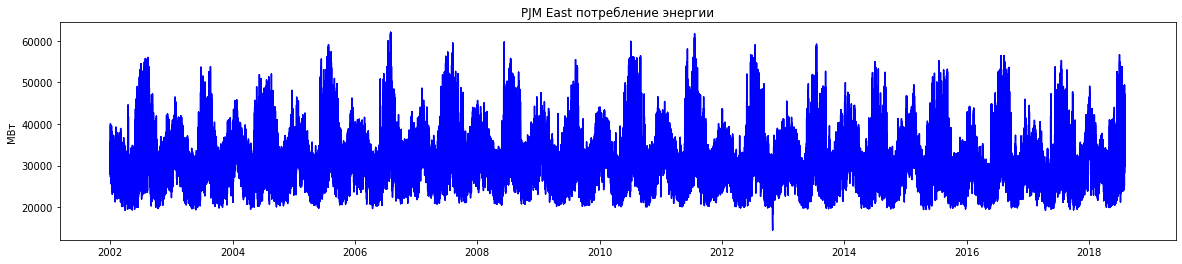

In [4]:
plt.figure(figsize =(20,4))
plt.plot( data.index, data['PJME_MW'], 'b' )
plt.title('PJM East потребление энергии' )
plt.ylabel ( 'МВт' )
plt.show()

Рис.1. Потребление энергии

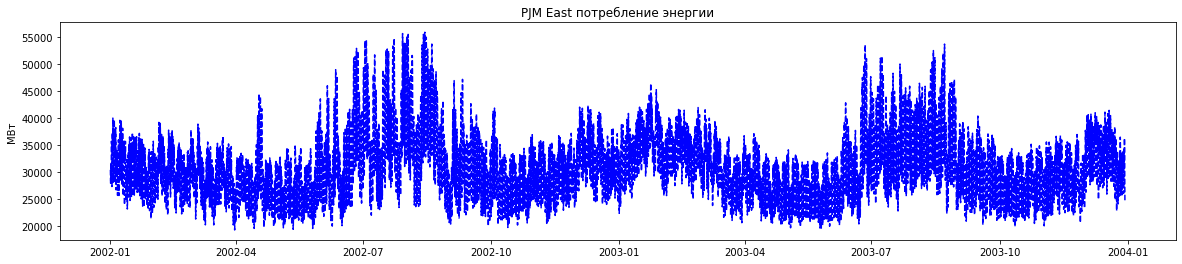

In [5]:
date_time =data['PJME_MW']
date_time.index = pd.date_range(data.index[0], periods=data.index.shape[0], freq="H")
plt.figure(figsize =(20,4))
plt.plot( date_time.index[:24*7*104], date_time.values[:24*7*104], '--b' )

plt.title('PJM East потребление энергии' )
plt.ylabel ( 'МВт' )
plt.show()

## Brent 2010-2019
Перейдем ко второму примеру. Цена нефти марки Brent. Данные по дням от 2010 до 2019 . Данные были обработаны, но не меняли основное содержание ключевого признака. Отличие от исходного описания - дополнение признаками по календарю, как и в первом примере.

In [6]:

#path_brent = 'brent_cl_m5_20120101_20121231.csv'
#brent_data['Значение'] =brent_data['CLOSE']
#brent_data = pd.read_csv(path_brent,sep = ';', index_col=[0], parse_dates=[0])
path_brent = 'my_BRENT2019.csv'
brent_data = pd.read_csv(path_brent,sep = ',', index_col=[0], parse_dates=[0])
brent_data.head()

,Значение,year,month,dayofmonth,quarter,dayofyear,weekofyear,dayofweek,is_holiday,is_prev_holiday,is_next_holiday
Дата,,,,,,,,,,,
2010-09-01,76.37,2010,9,1,3,244,35,2,0,0,0
2010-09-02,76.89,2010,9,2,3,245,35,3,0,0,0
2010-09-03,76.57,2010,9,3,3,246,35,4,0,0,0
2010-09-04,76.62,2010,9,4,3,247,35,5,0,0,0
2010-09-05,76.63,2010,9,5,3,248,35,6,0,1,0


Основные статистики ряда остались без изменений.

In [7]:
brent_data.describe()

,Значение,year,month,dayofmonth,quarter,dayofyear,weekofyear,dayofweek,is_holiday,is_prev_holiday,is_next_holiday
count,2667.000000,2667.000000,2667.00000,2667.000000,2667.000000,2667.000000,2667.000000,2667.000000,2667.000000,2667.000000,2667.000000
mean,81.533547,2014.661042,6.51706,15.715786,2.505062,182.901762,26.486689,2.537308,0.027747,0.026997,0.029621
std,26.349469,2.663525,3.43026,8.780275,1.112684,104.741067,14.935147,1.894937,0.164277,0.162104,0.169572
min,27.850000,2010.000000,1.00000,1.000000,1.000000,2.000000,1.000000,0.000000,0.000000,0.000000,0.000000
25%,56.840000,2012.000000,4.00000,8.000000,2.000000,92.000000,14.000000,1.000000,0.000000,0.000000,0.000000
50%,77.710000,2015.000000,7.00000,16.000000,3.000000,183.000000,27.000000,2.000000,0.000000,0.000000,0.000000
75%,108.190000,2017.000000,9.00000,23.000000,3.000000,273.000000,39.000000,4.000000,0.000000,0.000000,0.000000
max,126.900000,2019.000000,12.00000,31.000000,4.000000,366.000000,53.000000,6.000000,1.000000,1.000000,1.000000


In [8]:
import statsmodels.formula.api as smf
import statsmodels.tsa.api as smt
import statsmodels.api as sm
import scipy.stats as scs


# Задание

Обозначения:

p - глубина истории, сколько измерений назад учитываем в моделях

h - горизонт прогноза , на сколько измерений вперед смотрим при моделировании (как далеко предсказываем)

1. Прочитайте базу "Потребление Энергии" и сделайте модель для сезонных изменений по data_exp_1 с глубиной прогноза h=1 и h=10 по образцу из примера для обработки ряда "цена Нефти" .

2. Оцените ошибку модели из п.1 .

3. Сделайте вывод о том, как изменилась ошибка модели по значениям h.
4. Попробуйте предположить характер ряда (стационарный или нет, с трендом, с сезоном, с циклом) для рядов из списка и аргументируйте свой ответ (одна строка):

    а) Изменение температуры за окном :).
    
    б) Количество денег, которые тратят покупатели в интернет магазине.
    
    в) Вес растущего котенка.
    
    г) Прирост объема деревьев в лесу от времени

Интересные ссылки:
1. Пакет стат.моделирования https://www.statsmodels.org/stable/
1. Пакет для прогнозирования во временных рядах от FaceBook https://facebook.github.io/prophet/docs/quick_start.html

# Задание 1

# Потребление энергии с Глубиной 4

In [9]:

b_ar = brent_data['Значение'].values
b_s = pd.DataFrame(data = brent_data[['Значение']])


#import matplotlib.dates as mdates
train = b_s.iloc[:-10, :]
test = b_s.iloc[-10:, :]


N2 = 24*7

b_s['z_data'] = (b_s['Значение'] - b_s['Значение'].rolling(window=N2).mean()) / b_s['Значение'].rolling(window=N2).std()
b_s['zp_data'] = b_s['z_data'] - b_s['z_data'].shift(N2)

In [10]:
b_s.head()

,Значение,z_data,zp_data
Дата,,,
2010-09-01,76.37,NaN,NaN
2010-09-02,76.89,NaN,NaN
2010-09-03,76.57,NaN,NaN
2010-09-04,76.62,NaN,NaN
2010-09-05,76.63,NaN,NaN


In [44]:
b_en = data['PJME_MW'].values
data=data.resample('W').mean()
b_sen = pd.DataFrame(data = data[['PJME_MW']])
b_sen.head()

,PJME_MW
Date,
2002-01-06,32392.160839
2002-01-13,31487.386905
2002-01-20,31452.880952
2002-01-27,30141.529762
2002-02-03,29196.488095


Text(0.5, 1.0, 'ENERGY')

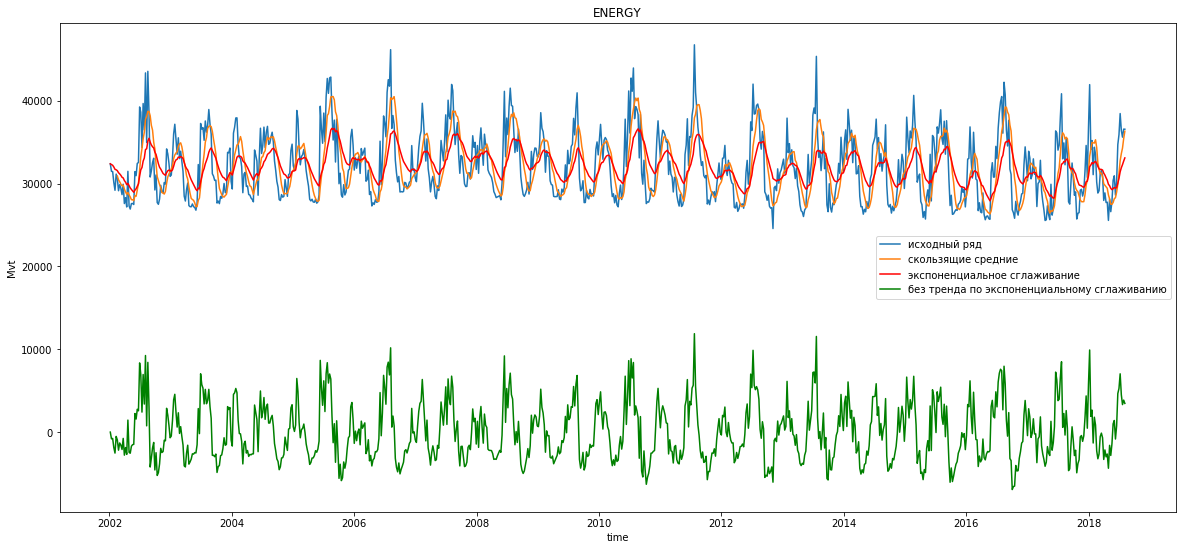

In [45]:
def exponential_smoothing(series, alpha):
    result = [series[0]] # first value is same as series
    for n in range(1, len(series)):
        result.append(alpha * series[n] + (1 - alpha) * result[n-1])
    return result
N2=7
b_en_exp_1 = exponential_smoothing(data['PJME_MW'], 0.1)

plt.figure(figsize=(20, 9))
plt.plot(b_sen.index, b_sen['PJME_MW'], label='исходный ряд')
plt.plot(b_sen['PJME_MW'].rolling(window=N2).mean(), label="скользящие средние");

plt.plot(b_sen.index,b_en_exp_1, color = 'red', label="экспоненциальное сглаживание");
plt.plot(b_sen.index, b_sen['PJME_MW'] - b_en_exp_1, color = 'green', label="без тренда по экспоненциальному сглаживанию");
plt.xlabel('time')
plt.ylabel('Mvt')
plt.legend()
plt.title('ENERGY')

In [46]:
# d_data=data.resample('D').mean()
d_data=data.resample('W').mean()

In [47]:
d_data

,PJME_MW,year,month,dayofmonth,quarter,dayofyear,weekofyear,dayofweek,hour,is_holiday,is_prev_holiday,is_next_holiday
Date,,,,,,,,,,,,
2002-01-06,32392.160839,2002.0,1.000000,3.517483,1.0,3.517483,1.0,3.517483,11.580420,0.160839,0.000000,0.167832
2002-01-13,31487.386905,2002.0,1.000000,10.000000,1.0,10.000000,2.0,3.000000,11.500000,0.000000,0.000000,0.000000
2002-01-20,31452.880952,2002.0,1.000000,17.000000,1.0,17.000000,3.0,3.000000,11.500000,0.000000,0.142857,0.000000
2002-01-27,30141.529762,2002.0,1.000000,24.000000,1.0,24.000000,4.0,3.000000,11.500000,0.142857,0.000000,0.142857
2002-02-03,29196.488095,2002.0,1.428571,17.714286,1.0,31.000000,5.0,3.000000,11.500000,0.000000,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...
2018-07-08,38459.982143,2018.0,7.000000,5.000000,3.0,186.000000,27.0,3.000000,11.500000,0.142857,0.142857,0.142857
2018-07-15,36420.035714,2018.0,7.000000,12.000000,3.0,193.000000,28.0,3.000000,11.500000,0.000000,0.000000,0.000000
2018-07-22,35612.095238,2018.0,7.000000,19.000000,3.0,200.000000,29.0,3.000000,11.500000,0.000000,0.000000,0.000000


Text(0.5, 1.0, 'PJME_MW')

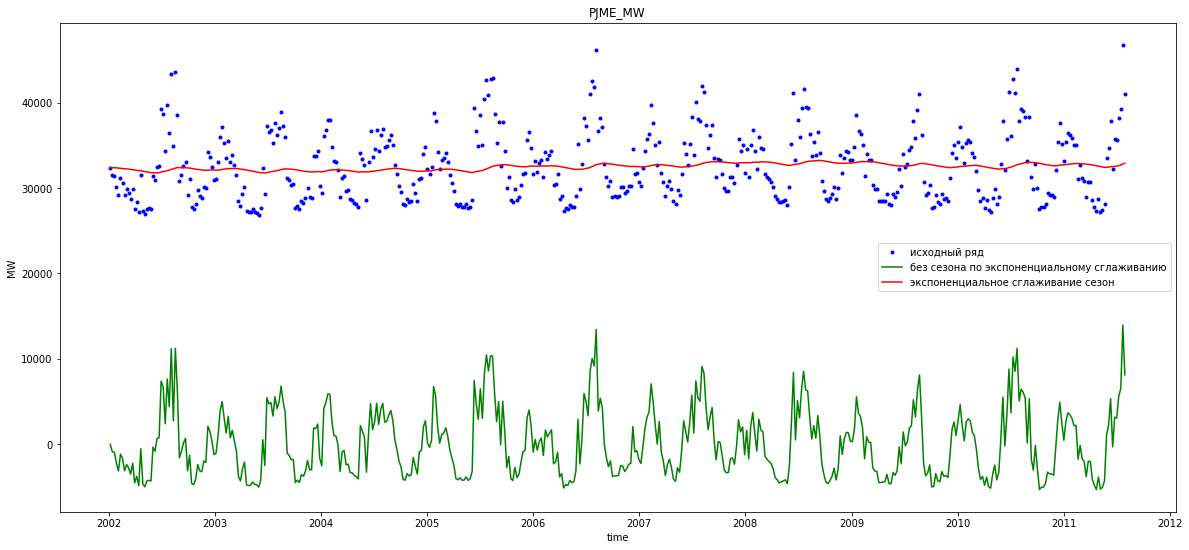

In [48]:
data_exp_2 = exponential_smoothing(d_data['PJME_MW']  , 0.01)
plt.figure(figsize=(20, 9))
plt.plot(d_data.index[:500], d_data['PJME_MW'].values[:500], '.b',label='исходный ряд')

plt.plot(d_data.index[:500],d_data['PJME_MW'].values[:500] - data_exp_2[:500] , color = 'green', label="без сезона по экспоненциальному сглаживанию");

plt.plot(d_data.index[:500],data_exp_2[:500] , color = 'red', label="экспоненциальное сглаживание сезон");

plt.xlabel('time')
plt.ylabel('MW')
plt.legend()
plt.title('PJME_MW')

In [49]:
# data_exp_2 - массив с экспонентой от дневных данных
# b_sen - массив до проведения ресемплинга
# из этого следует ошибка сопоставления ряда и индекса

print(f'data_exp_2: {len(data_exp_2)} vs b_sen: {len(b_sen)}')

data_exp_2: 866 vs b_sen: 866


data_exp_2 - по дневному ресемплингу, а b_sen по часовому ряду ()

In [50]:
b_sen.shape 

(866, 1)

In [51]:
print(data_exp_2[0])
print(b_sen.head())


32392.16083916084
                 PJME_MW
Date                    
2002-01-06  32392.160839
2002-01-13  31487.386905
2002-01-20  31452.880952
2002-01-27  30141.529762
2002-02-03  29196.488095


In [52]:
# заменим на недельный индекс
data_exp_2 = pd.DataFrame(data = data_exp_2, index = d_data.index)
# и далее код отработает, как было задумано

#без тренда 
en_data_trend_free = (b_sen['PJME_MW'] - data_exp_2.iloc[:,0])

en_data_trend_free.head()
#DF_energy = sm.tsa.stattools.adfuller(en_data_trend_free , regression = 'ctt')
#DF_energy

Date
2002-01-06       0.000000
2002-01-13    -895.726195
2002-01-20    -920.929826
2002-01-27   -2209.958206
2002-02-03   -3123.449874
Freq: W-SUN, dtype: float64

In [53]:
print(data_exp_2.head())
print(b_sen.head())

                       0
Date                    
2002-01-06  32392.160839
2002-01-13  32383.113100
2002-01-20  32373.810778
2002-01-27  32351.487968
2002-02-03  32319.937969
                 PJME_MW
Date                    
2002-01-06  32392.160839
2002-01-13  31487.386905
2002-01-20  31452.880952
2002-01-27  30141.529762
2002-02-03  29196.488095


Берете серию b_sen['PJME_MW'] и вычитаете из нее серию data_exp_2.iloc[:,0] - размеры разные, но благодаря индексации Date это можно собрать в один результат

In [54]:
en_data_trend_free.shape

(866,)


В нефти брали одинаковый ресемплинг , тут не одинаковый , поэтому результат по более длинным - одна ячейка  data_exp_2 вычитается из 24-х ячеек b_sen['PJME_MW'] - оно может и пускай, но это 2 операции - ресемплинг делает среднее по дням, на него накрутили сглаживание, а вычитаете сглаживание из ряда без ресемплинга (данные ресемплинга не очень удобные для работы потом, т.к. для получения результата нужно увидеть все окно , а относится результат к средней точке окна по времени) 

In [55]:
df= pd.DataFrame(data_exp_2)
# df.head()
 # добавили историю на глубину 3 измерения от текущего (р=3)
df['t'] = 0
df.iloc[1:,1]=df.iloc[:-1,0].values
df['t1']=0
df.iloc[2:,2]=df.iloc[:-2,0].values
df['t2']=0
df.iloc[3:,3]=df.iloc[:-3,0].values
df['t3']=0
df.iloc[4:,4]=df.iloc[:-4,0].values
df.fillna(0)
# добавили сглаживание (3 вида - просто для коллекции)
df['exp_0_01'] = exponential_smoothing(df[0], 0.01)
df['exp_0_03'] = exponential_smoothing(df[0], 0.03)
df['exp_0_08'] = exponential_smoothing(df[0], 0.08)
# добавим разности - 1-й порядок
df['diff1'] = 0
df['diff1'].iloc[1:] = df.iloc[:-1,0]-df.iloc[1:,0]


df.head()

C:\Anaconda\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)


,0,t,t1,t2,t3,exp_0_01,exp_0_03,exp_0_08,diff1
Date,,,,,,,,,
2002-01-06,32392.160839,0.000000,0.000000,0.000000,0.000000,32392.160839,32392.160839,32392.160839,0.0
2002-01-13,32383.113100,32392.160839,0.000000,0.000000,0.000000,32392.070362,32391.889407,32391.437020,0.0
2002-01-20,32373.810778,32383.113100,32392.160839,0.000000,0.000000,32391.887766,32391.347048,32390.026921,0.0
2002-01-27,32351.487968,32373.810778,32383.113100,32392.160839,0.000000,32391.483768,32390.151276,32386.943804,0.0
2002-02-03,32319.937969,32351.487968,32373.810778,32383.113100,32392.160839,32390.768310,32388.044877,32381.583338,0.0


In [22]:
''' далее он ругался на дублирующие индексы, скорее всего ,в уроке приводили к дня, а здесь
исходные массив, но чтобы сохрнаить задумку - можно обойти так:'''
# добавим разности - 1-й порядок
#df['diff1'] = 0

#df['diff1'].iloc[1:] = pd.DataFrame(df.iloc[:-1,0].reset_index() - df.iloc[1:,0].reset_index()).values[:,1]
# Делаем присвоение серии == таблице!!

#df.columns

' далее он ругался на дублирующие индексы, скорее всего ,в уроке приводили к дня, а здесь\nисходные массив, но чтобы сохрнаить задумку - можно обойти так:'

In [56]:
df['diff1'] = 0
df['diff1'] = df[0].diff(1)

In [57]:
df.columns
df.fillna(0, inplace=True)

In [58]:
df.head()

,0,t,t1,t2,t3,exp_0_01,exp_0_03,exp_0_08,diff1
Date,,,,,,,,,
2002-01-06,32392.160839,0.000000,0.000000,0.000000,0.000000,32392.160839,32392.160839,32392.160839,0.000000
2002-01-13,32383.113100,32392.160839,0.000000,0.000000,0.000000,32392.070362,32391.889407,32391.437020,-9.047739
2002-01-20,32373.810778,32383.113100,32392.160839,0.000000,0.000000,32391.887766,32391.347048,32390.026921,-9.302321
2002-01-27,32351.487968,32373.810778,32383.113100,32392.160839,0.000000,32391.483768,32390.151276,32386.943804,-22.322810
2002-02-03,32319.937969,32351.487968,32373.810778,32383.113100,32392.160839,32390.768310,32388.044877,32381.583338,-31.549999


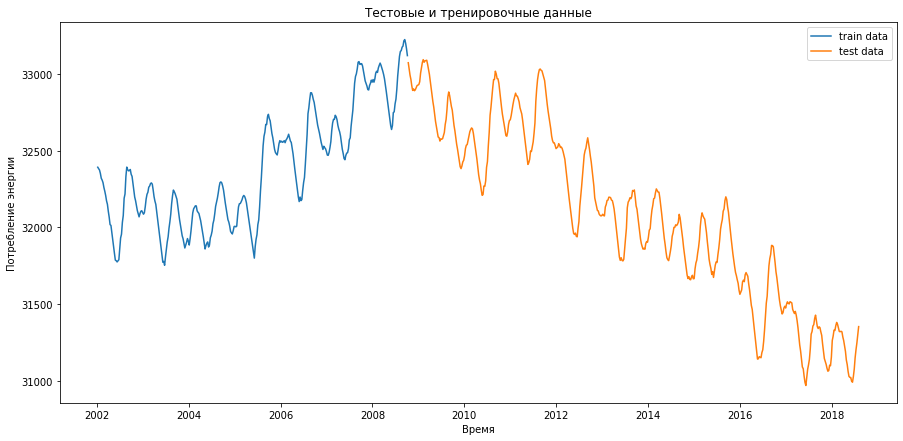

In [59]:
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.preprocessing import StandardScaler

from sklearn.metrics import mean_absolute_error, mean_squared_error, median_absolute_error, r2_score
scl =StandardScaler()
scly =StandardScaler()

# сделаем примеры и модель 
def split_data_b( data, split_date ):
    return data.loc[data.index.get_level_values('Date') <= split_date].copy(), \
           data.loc[data.index.get_level_values('Date') >  split_date].copy()

train_b, test_b = split_data_b( df, '10-10-2008')

X_train_b = train_b.iloc[:-1,:]
y_train_b = train_b[df.columns[0]].values[1:]
X_test_b = test_b.iloc[:-1,:]
y_test_b = test_b[df.columns[0]].values[1:]


plt.figure( figsize=( 15, 7 ))
plt.xlabel('Время')
plt.ylabel('Потребление энергии')
plt.plot(train_b.index.get_level_values('Date'),train_b[df.columns[0]], label='train data' )
plt.plot(test_b.index.get_level_values('Date'),test_b[df.columns[0]], label='test data')
plt.title( 'Тестовые и тренировочные данные' )
plt.legend()
plt.show()

In [60]:
b_s.head()

,Значение,z_data,zp_data
Дата,,,
2010-09-01,76.37,NaN,NaN
2010-09-02,76.89,NaN,NaN
2010-09-03,76.57,NaN,NaN
2010-09-04,76.62,NaN,NaN
2010-09-05,76.63,NaN,NaN


b_s - это нефть - зачем она тут?

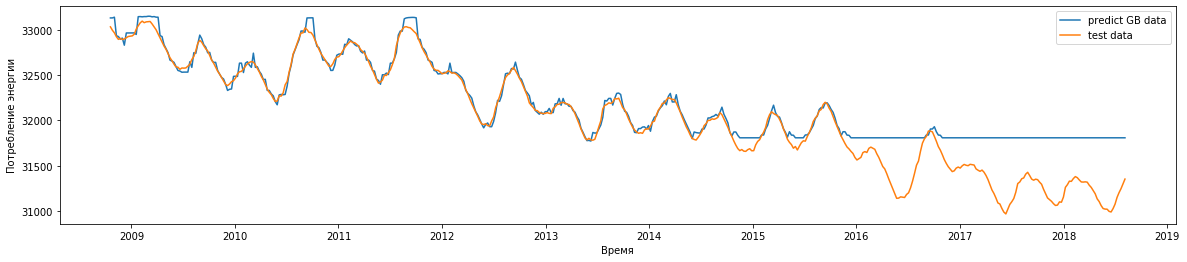

ошибка градиентного бустинга :   0.484046161571818 %


In [61]:
def mean_absolute_percentage_error(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

model_gb = GradientBoostingRegressor(max_depth=15, random_state=0, n_estimators=100)
model_gb.fit( X_train_b, y_train_b ) 
X_test_pred_gb = model_gb.predict(X_test_b)

plt.figure( figsize=( 20, 4 ))

plt.xlabel('Время')
plt.ylabel('Потребление энергии')
plt.plot(test_b.index[1:],X_test_pred_gb, label='predict GB data' )
plt.plot(test_b.index[1:],y_test_b, label='test data')
#plt.plot(b_s.loc['10-10-2008':].index, b_s.loc['10-10-2008':]['Значение'], label='исходный ряд')

plt.legend()
plt.show()

er_g = mean_absolute_percentage_error(y_true=y_test_b, y_pred=X_test_pred_gb)

print('ошибка градиентного бустинга :  ', er_g, '%')


# ПРОГНОЗ НА 4 ДНЯ  

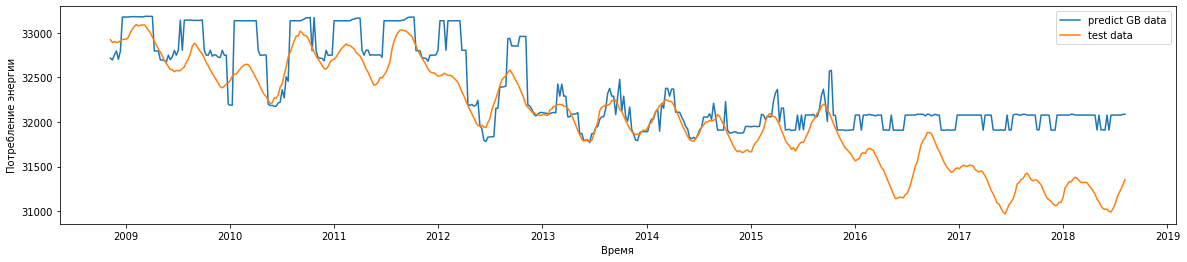

ошибка градиентного бустинга :   1.027786661891731 %


In [71]:
h=4


X_train_b = train_b.iloc[:-h,:]
y_train_b = train_b[df.columns[0]].values[h:]
X_test_b = test_b.iloc[:-h,:]
y_test_b = test_b[df.columns[0]].values[h:]


model_gb = GradientBoostingRegressor(max_depth=15, random_state=0, n_estimators=100)
model_gb.fit( X_train_b, y_train_b ) 
X_test_pred_gb = model_gb.predict(X_test_b)

plt.figure( figsize=( 20, 4 ))

plt.xlabel('Время')
plt.ylabel('Потребление энергии')
plt.plot(test_b.index[h:],X_test_pred_gb, label='predict GB data' )
plt.plot(test_b.index[h:],y_test_b, label='test data')
#plt.plot(b_s.loc['10-10-2008':].index, b_s.loc['10-10-2008':]['Значение'], label='исходный ряд')

plt.legend()
plt.show()

er_g = mean_absolute_percentage_error(y_true=y_test_b, y_pred=X_test_pred_gb)

print('ошибка градиентного бустинга :  ', er_g, '%')






# X_train_b = train_b.iloc[:-h,:]
# y_train_b = train_b[df.columns[0]].values[h:]
# X_test_b = test_b.iloc[:-h,:]
# y_test_b = test_b[df.columns[0]].values[h:]

# model_gb.fit( X_train_b, y_train_b ) 
# X_test_pred_gb = model_gb.predict(X_test_b)

# plt.figure( figsize=( 20, 4 ))

# plt.xlabel('Время')
# plt.ylabel('Цена Brent')
# plt.plot(test_b.index[h:],X_test_pred_gb, label='predict GB data' )
# plt.plot(test_b.index[h:],y_test_b, label='test data')
# plt.plot(b_s.loc['2018-11-02':].index, b_s.loc['2018-11-02':]['Значение'], label='исходный ряд')

# plt.legend()
# plt.show()

# er_g = mean_absolute_percentage_error(y_true=y_test_b, y_pred=X_test_pred_gb)

# print('ошибка градиентного бустинга :  ', er_g, '%')

In [68]:
X_test_pred_gb.shape

(509,)

In [69]:
y_test_b.shape

(509,)

In [70]:
test_b.index[h:].shape

(509,)

In [33]:
Попробуйте предположить характер ряда (стационарный или нет, с трендом, с сезоном, с циклом) для рядов из списка и аргументируйте свой ответ (одна строка):

а) Изменение температуры за окном :).

б) Количество денег, которые тратят покупатели в интернет магазине.

в) Вес растущего котенка.

г) Прирост объема деревьев в лесу от времени

SyntaxError: invalid syntax (<ipython-input-33-df43841bf91c>, line 1)

In [ ]:
a) стационар (На каком интервале?)
б) нестационар, но может быть и стационарныем если выручка магазина одинаковая год к году
в) нестационарный
г) стационарный (На каком интервале?)

